In [34]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

##
## Loading and handling timeseries
##

dateParser = lambda dates : pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv')
## Reading csv as time series data with date parsing options and timeobject as index for Month column 
data = pd.read_csv('AirPassengers.csv', parse_dates = True, index_col = 'Month', date_parser = dateParser)

#print("\n Data Types:")
#print(data.dtypes)
#print("\n Index:")
#print(data.index)

ts = data['#Passengers']
print(ts.head())

## Selecting value with indexing techniques and end index is inclusive not like numeric index where it's exclusive
## Indices have to be sorted
#print(ts['1949-04-01'])
#print(ts[dt.datetime(1949,4,1)])

#print(ts['1949-01-01':'1949-04-01'])
#print(ts[:'1949-04-01'])

## Access all the values of an year
#print(ts['1949'])


Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


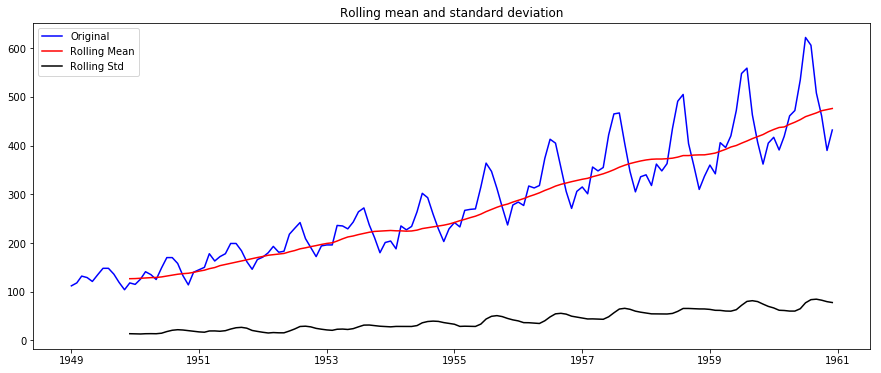

Results of Dickey-Fuller Test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [36]:
##
## Checking stationarity of a timeseries
##
## A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time
## Constant statistical properties over time, ie. the following:
## 1 Constant mean
## 2 Constant variance
## 3 Autocovariance that does not depend on time

## Methods - 1. Plotting rolling statistics (Visual technique), 2. Dickey-Fuller Test

#plt.plot(ts)

def testStationarity(timeseries):
    # Getting rolling statistics
    #rolMean = pd.rolling_mean(timeseries, window = 12) # Deprecated
    #rolStd = pd.rolling_std(timeseries, window = 12) # Deprecated
    rolMean = timeseries.rolling(window = 12, center=False).mean()
    rolStd = timeseries.rolling(window = 12, center=False).std()
    
    # Plotting rolling statistics
    original = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolMean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolStd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling mean and standard deviation')
    plt.show(block = False)
    
    # Dickey-Fuller Test
    print('Results of Dickey-Fuller Test')
    dfTest = adfuller(timeseries, autolag = 'AIC')
    dfOutput = pd.Series(dfTest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dfTest[4].items():
        dfOutput['Critical Value (%s)'%key] = value
    
    print(dfOutput)
    
testStationarity(ts)
## Though the variation in standard deviation is small, mean is clearly increasing with time and
## this is not a stationary series. Also, the test statistic is way more than the critical values.
## Note that the signed values should be compared and not the absolute values.


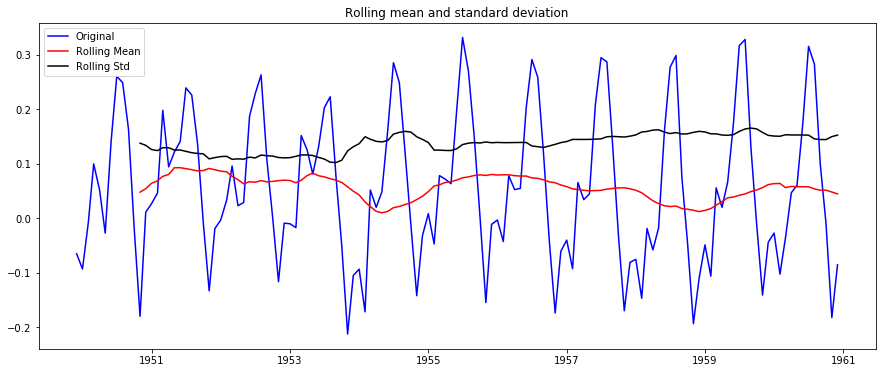

Results of Dickey-Fuller Test
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


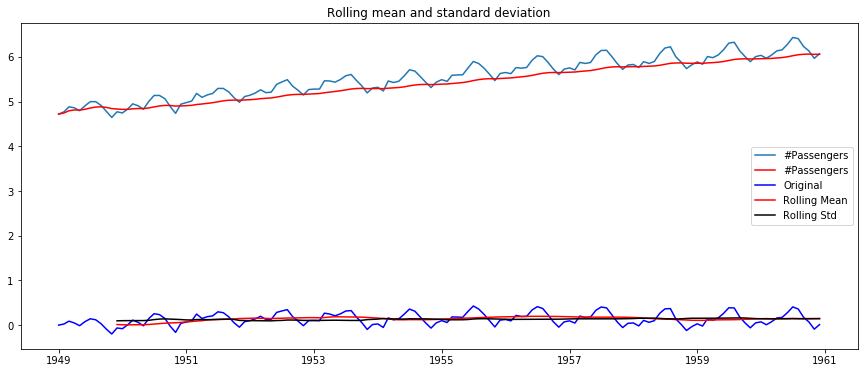

Results of Dickey-Fuller Test
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [55]:
##
## Making Time Series Stationary
##

## Trend and Seasonality are making a timeseries non stationary
## The underlying principle is to model or estimate the trend and seasonality in the series and
## remove those from the series to get a stationary series
## Then statistical forecasting techniques can be implemented on this series
## The final step would be to convert the forecasted values into the original scale
## by applying trend and seasonality constraints back.

### Estimating and Eliminating Trend
ts_log = np.log(ts)
# plt.plot(ts_log)

## Methods for removing the trend 
## Aggregation – taking average for a time period like monthly/weekly averages
## Smoothing – taking rolling averages
## Polynomial Fitting – fit a regression model
moving_avg = ts_log.rolling(window=12, center=False).mean()
# plt.plot(moving_avg, color = 'red')

ts_log_moving_average_diff = ts_log - moving_avg
# print(ts_log_moving_average_diff.head(12))
ts_log_moving_average_diff.dropna(inplace = True)
testStationarity(ts_log_moving_average_diff)

## This looks like a much better series. The rolling values appear to be varying slightly but
## there is no specific trend. Also, the test statistic is smaller than the 5% critical values
## so we can say with 95% confidence that this is a stationary series.

## Weighted Moving Average where more recent values are given a higher weight
## A popular one is exponentially weighted moving average where weights are assigned to
## all the previous values with a decay factor.

# expWeightedAverage = pd.ewma(ts_log, halflife = 12)
expWeightedAverage = ts_log.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
##plt.plot(ts_log)
##plt.plot(expWeightedAverage, color = 'red')

ts_log_ewma_diff = ts_log - expWeightedAverage
testStationarity(ts_log_ewma_diff)
